In [44]:
# Importing Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# wget Data

In [45]:

# # 1.
# data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'

# # 2. Linux or cmd
# # The below is for Linux
# # !wget $data -o CaliHousing.csv 


# # 2. For windows
# # wget for windows is below. It fetches teh data and saves to csv locally
# !python -m wget $data -o Credit_card_data.csv

In [46]:
# Now reading the file received from wget into a dataframe

df= pd.read_csv('Credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [47]:
# Creating target variable by mapping yes to 1 and no to 0.

df["target"] = np.where(df["card"] == "yes", 1, 0)

# Dropping "card" column
del df["card"]
df.head()

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,target
0,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12,1
1,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13,1
2,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5,1
3,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7,1
4,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5,1


In [48]:
df.columns

Index(['reports', 'age', 'income', 'share', 'expenditure', 'owner', 'selfemp',
       'dependents', 'months', 'majorcards', 'active', 'target'],
      dtype='object')

In [49]:
# Separating categorical and numerical columns

numerical = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards', 'active']

categorical = ['owner', 'selfemp']

# Train-Test-Val Split 60-20-20

In [50]:
# Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use train_test_split funciton for that with random_state=1.

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Check size of the datasets
len(df_train), len(df_val), len(df_test)


(791, 264, 264)

In [51]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

del df_train['target']
del df_val['target']
del df_test['target']

### Question 1:

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [52]:
from sklearn.metrics import roc_auc_score

for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))
    
# ANs: Share

  reports, 0.717
      age, 0.524
   income, 0.591
    share, 0.989
expenditure, 0.991
dependents, 0.533
   months, 0.529
majorcards, 0.534
   active, 0.604


> Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

> ``` LogisticRegression(solver='liblinear', C=1.0, max_iter=1000) ```

In [53]:
# One Hot Encoding using Dict Vectorizer and training the model

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [54]:
# Validation predictions

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
(y_val == y_pred).mean()

0.678030303030303

## Question 2:

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [55]:
round((roc_auc_score(y_val, y_pred)),3)

# Answer: 0.995 

0.995

## Question 3:

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8


In [59]:
scores = []

thresholds = np.arange(start=0.0, stop=1.0, step=0.01)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, p, r))
    
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'p', 'r']
    df_scores = pd.DataFrame(scores, columns=columns)
    
df_scores

,threshold,tp,fp,fn,tn,p,r
0,0.00,211,53,0,0,0.799242,1.000000
1,0.01,211,34,0,19,0.861224,1.000000
2,0.02,211,31,0,22,0.871901,1.000000
3,0.03,211,24,0,29,0.897872,1.000000
4,0.04,211,22,0,31,0.905579,1.000000
...,...,...,...,...,...,...,...
95,0.95,204,0,7,53,1.000000,0.966825
96,0.96,204,0,7,53,1.000000,0.966825
97,0.97,203,0,8,53,1.000000,0.962085
98,0.98,203,0,8,53,1.000000,0.962085


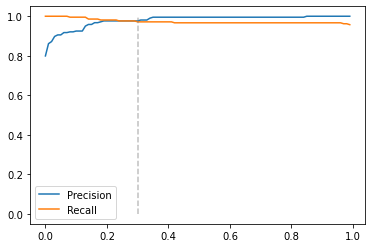

In [64]:
# Plotting precision and recall against threshold

plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')

plt.vlines(0.3, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

# Ans: 0.3

## Question 4:

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

In [68]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)
df_scores

,threshold,tp,fp,fn,tn,p,r,f1
0,0.00,211,53,0,0,0.799242,1.000000,0.888421
1,0.01,211,34,0,19,0.861224,1.000000,0.925439
2,0.02,211,31,0,22,0.871901,1.000000,0.931567
3,0.03,211,24,0,29,0.897872,1.000000,0.946188
4,0.04,211,22,0,31,0.905579,1.000000,0.950450
...,...,...,...,...,...,...,...,...
95,0.95,204,0,7,53,1.000000,0.966825,0.983133
96,0.96,204,0,7,53,1.000000,0.966825,0.983133
97,0.97,203,0,8,53,1.000000,0.962085,0.980676
98,0.98,203,0,8,53,1.000000,0.962085,0.980676


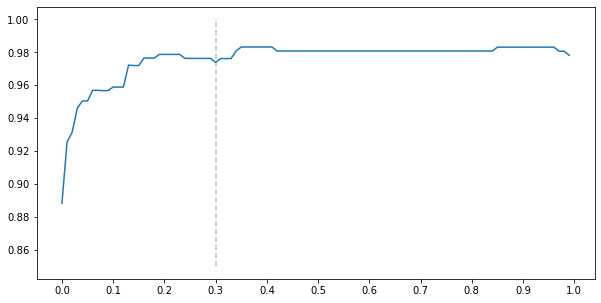

In [74]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
# plt.vlines(0.3, 0.85, 01.0, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

In [79]:
# Finding max threshold

df_scores[df_scores["f1"] == df_scores["f1"].max()]

# Ans: 0.4

,threshold,tp,fp,fn,tn,p,r,f1
35,0.35,205,1,6,52,0.995146,0.971564,0.983213
36,0.36,205,1,6,52,0.995146,0.971564,0.983213
37,0.37,205,1,6,52,0.995146,0.971564,0.983213
38,0.38,205,1,6,52,0.995146,0.971564,0.983213
39,0.39,205,1,6,52,0.995146,0.971564,0.983213
40,0.40,205,1,6,52,0.995146,0.971564,0.983213
41,0.41,205,1,6,52,0.995146,0.971564,0.983213



## Question 5:

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

In [80]:
# Function to train the model

def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
#     Return dv to be able to do one hot encoding, and model to be able to use the DV
    return dv, model


# Model for making predictions, using dv and model from above

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
#     Predictions are in second columns
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [86]:
from sklearn.model_selection import KFold

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.target.values
    y_val = df_val.target.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

# ANs: 0.003

0.996 +- 0.003


## Question 6:

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

In [89]:
n_splits = 5

# For different values of C

for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.target.values
        y_val = df_val.target.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.5f +- %.3f' % (C, np.mean(scores), np.std(scores)))
    
# Ans: 10

C=0.01 0.99546 +- 0.004
C=0.1 0.99654 +- 0.003
C=1 0.99647 +- 0.003
C=10 0.99664 +- 0.003
